<a href="https://colab.research.google.com/github/loissnijders/Process-mining/blob/main/arima_lois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
import io
import pandas as pd
import re
from datetime import timedelta
import numpy as np

In [3]:
!wget -O training.csv https://surfdrive.surf.nl/files/index.php/s/aNVxBfvZl273kKN/download   
!wget -O test.csv https://surfdrive.surf.nl/files/index.php/s/0lJ3j0RlMeychGj/download   


path_test = '/content/test.csv'
path_train = '/content/training.csv'

--2022-03-16 13:44:24--  https://surfdrive.surf.nl/files/index.php/s/aNVxBfvZl273kKN/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26049572 (25M) [text/csv]
Saving to: ‘training.csv’

training.csv        100%[===================>]  24.84M  17.7MB/s    in 1.4s    

2022-03-16 13:44:26 (17.7 MB/s) - ‘training.csv’ saved [26049572/26049572]

--2022-03-16 13:44:26--  https://surfdrive.surf.nl/files/index.php/s/0lJ3j0RlMeychGj/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5819692 (5.5M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]   5.55M  6.68MB/s    in 0.

In [4]:
path_test = '/content/test.csv'
path_train = '/content/training.csv'

In [5]:
# # This is for when you read the data in jupyther notebooks
# path_test = '/content/BPI_Challenge_2012-test.csv'
# path_train = '/content/BPI_Challenge_2012-training.csv'

In [6]:
df_train = pd.read_csv (path_train)
df_test = pd.read_csv (path_test)

In [7]:
# Keeping in test set only cases that started in test and not in train

train_cases = list(set(list(df_train['case concept:name'])))
test_cases = list(set(list(df_test['case concept:name'])))
# test_delete = [item for item in test_cases if item in train_cases]
test_keep = [item for item in test_cases if item not in train_cases]

df_test = df_test[df_test['case concept:name'].isin(test_keep)]

In [8]:
import matplotlib.pyplot as plt
import datetime

In [9]:
df_test['event time:timestamp']= pd.to_datetime(df_test['event time:timestamp'], dayfirst=True)
df_train['event time:timestamp']= pd.to_datetime(df_train['event time:timestamp'], dayfirst=True)

In [10]:
df_train = df_train.sort_values(by=['case concept:name', 'event time:timestamp'])

df_train = df_train.assign(nexttime=(df_train.groupby('case concept:name')['event time:timestamp'].shift(-1)))

In [11]:
df_test = df_test.sort_values(by=['case concept:name', 'event time:timestamp'])

df_test = df_test.assign(nexttime=(df_test.groupby('case concept:name')['event time:timestamp'].shift(-1)))

In [12]:
df_train['tonext'] = (df_train.nexttime - df_train['event time:timestamp']).astype('timedelta64[s]')
df_test['tonext'] = (df_test.nexttime - df_test['event time:timestamp']).astype('timedelta64[s]')

In [13]:
df_test = df_test.groupby('case concept:name',as_index = False).apply(lambda x: 
  x.reset_index(drop = True)).reset_index().drop('level_0',axis = 1).rename(columns={"level_1": "actionorder"})
df_test.actionorder = df_test.actionorder + 1

In [14]:
df_test

,actionorder,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,nexttime,tonext
0,1,44964012621824,206324,2012-02-03T17:17:11.047+01:00,2500,A_SUBMITTED,COMPLETE,2012-02-03 17:17:11.047,2012-02-03 17:17:11.323,0.0
1,2,44964012621825,206324,2012-02-03T17:17:11.047+01:00,2500,A_PARTLYSUBMITTED,COMPLETE,2012-02-03 17:17:11.323,2012-02-03 17:17:42.964,31.0
2,3,44964012621826,206324,2012-02-03T17:17:11.047+01:00,2500,A_DECLINED,COMPLETE,2012-02-03 17:17:42.964,NaT,NaN
3,1,44968307589120,206327,2012-02-03T17:23:41.949+01:00,6000,A_SUBMITTED,COMPLETE,2012-02-03 17:23:41.949,2012-02-03 17:23:42.504,0.0
4,2,44968307589121,206327,2012-02-03T17:23:41.949+01:00,6000,A_PARTLYSUBMITTED,COMPLETE,2012-02-03 17:23:42.504,2012-02-03 17:24:23.379,40.0
...,...,...,...,...,...,...,...,...,...,...
47818,2,56203942035457,214376,2012-02-29T23:51:16.799+01:00,15000,A_PARTLYSUBMITTED,COMPLETE,2012-02-29 23:51:17.423,2012-02-29 23:52:01.287,43.0
47819,3,56203942035458,214376,2012-02-29T23:51:16.799+01:00,15000,W_Afhandelen leads,SCHEDULE,2012-02-29 23:52:01.287,2012-03-01 09:26:46.736,34485.0
47820,4,56203942035459,214376,2012-02-29T23:51:16.799+01:00,15000,W_Afhandelen leads,START,2012-03-01 09:26:46.736,2012-03-01 09:27:37.118,50.0
47821,5,56203942035460,214376,2012-02-29T23:51:16.799+01:00,15000,A_DECLINED,COMPLETE,2012-03-01 09:27:37.118,2012-03-01 09:27:41.325,4.0


In [15]:
df_train = df_train.groupby('case concept:name',as_index = False).apply(lambda x: 
  x.reset_index(drop = True)).reset_index().drop('level_0',axis = 1).rename(columns={"level_1": "actionorder"})
df_train.actionorder = df_train.actionorder + 1

In [16]:
# targets = np.array(list(set(df_train['event concept:name'])))
# labelEnc = preprocessing.LabelEncoder()
# new_target = labelEnc.fit_transform(targets)
# onehotEnc = preprocessing.OneHotEncoder()
# onehotEnc.fit(new_target.reshape(-1, 1))
# targets_trans = onehotEnc.transform(new_target.reshape(-1, 1))
# print("The original data")
# print(targets)
# print("The transform data using OneHotEncoder")
# print(targets_trans.toarray())

In [17]:
# zip_iterator = zip(targets.tolist(), targets_trans.toarray().tolist())
# activity_dict = dict(zip_iterator)

# df_train['onehot'] = df_train['event concept:name']

In [18]:
# df_train['onehot'].replace(activity_dict, inplace=True)

In [19]:
import sklearn.preprocessing as preprocessing
import numpy as np
import pandas as pd

In [20]:
xtrain = df_train['event concept:name']
xtrain = xtrain.to_numpy()
xtest = df_test['event concept:name']
xtest = xtest.to_numpy()
x = np.concatenate((xtrain, xtest))

In [21]:
xtrain2 = df_train.actionorder.to_numpy().reshape(-1, 1)
xtest2 = df_test.actionorder.to_numpy().reshape(-1, 1)

In [22]:
targets = x
labelEnc = preprocessing.LabelEncoder()
new_target = labelEnc.fit_transform(targets)
onehotEnc = preprocessing.OneHotEncoder()
onehotEnc.fit(new_target.reshape(-1, 1))
targets_trans = onehotEnc.transform(new_target.reshape(-1, 1))
print("The original data")
print(targets)
print("The transform data using OneHotEncoder")
print(targets_trans.toarray())

The original data
['A_SUBMITTED' 'A_PARTLYSUBMITTED' 'A_PREACCEPTED' ...
 'W_Afhandelen leads' 'A_DECLINED' 'W_Afhandelen leads']
The transform data using OneHotEncoder
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
#The one hot encoding is still correct at this point

targets_trans.toarray()[4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0.])

In [24]:
x_train = targets_trans.toarray()[:214377]
x_test = targets_trans.toarray()[214377:]

In [25]:
x_train = np.concatenate((x_train, xtrain2), axis = 1)
x_test = np.concatenate((x_test, xtest2), axis = 1)

In [26]:
x_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.]])

In [27]:
y_train = df_train.tonext.fillna(0).to_numpy()
y_test = df_test.tonext.fillna(0).to_numpy()

In [28]:
y_train

array([ 0., 53.,  0., ...,  0., 39.,  0.])

In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214377, 25), (214377,), (47823, 25), (47823,))

In [30]:
x_train, y_train

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 3.]]),
 array([ 0., 53.,  0., ...,  0., 39.,  0.]))

In [31]:
# y_train = y_train.reshape((214377, 1))
# y_test = y_test.reshape((47823, 1))

The time is now in seconds. Difficult to interpret so scale the seconds such that they are a value between 0 and 1. Where 1 is the longest time until a next activity. 

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.concatenate((y_train, y_test)).reshape(-1, 1))

MinMaxScaler()

In [34]:
y_test.reshape(-1, 1)

array([[ 0.],
       [31.],
       [ 0.],
       ...,
       [50.],
       [ 4.],
       [ 0.]])

In [35]:
y_test = scaler.transform(y_test.reshape(-1, 1))
y_train = scaler.transform(y_train.reshape(-1, 1))

In [36]:
y_train

array([[0.00000000e+00],
       [5.96426125e-06],
       [0.00000000e+00],
       ...,
       [0.00000000e+00],
       [4.38879601e-06],
       [0.00000000e+00]])

In [37]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214377, 25), (214377, 1), (47823, 25), (47823, 1))

In [38]:
y_test

array([[0.00000000e+00],
       [3.48853016e-06],
       [0.00000000e+00],
       ...,
       [5.62666155e-06],
       [4.50132924e-07],
       [0.00000000e+00]])

In [39]:
scaler.inverse_transform(y_test)

array([[ 0.],
       [31.],
       [ 0.],
       ...,
       [50.],
       [ 4.],
       [ 0.]])

In [51]:
df_train_try = df_train

df_train_try = df_train_try.set_index('event time:timestamp')

df_train_try = df_train_try[['tonext']]

df_train_try = df_train_try.dropna()

df_train_try.head()

,tonext
event time:timestamp,
2011-10-01 00:38:44.546,0.0
2011-10-01 00:38:44.880,53.0
2011-10-01 00:39:37.906,0.0
2011-10-01 00:39:38.875,39427.0
2011-10-01 11:36:46.437,356.0


In [52]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima


In [53]:
auto_arima(df_train_try, start_p=0, max_p= 5, start_q=0, max_q=5, max_d=5)

KeyboardInterrupt: ignored

In [54]:
plot_acf?

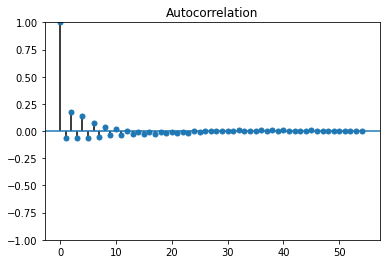

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [56]:
plot_acf(y_train)
plt.show()
plt.figure(figsize=(10,5))

In [70]:
ARIMA?

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


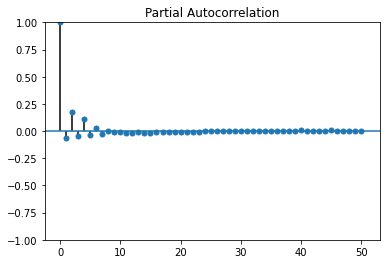

In [57]:

plot_pacf(y_train, lags=50)
plt.show()

In [58]:
ARIMA(y_train, order=(8, 1, 0))

NotImplementedError: ignored

In [59]:
import statsmodels.api as sm

In [61]:
model = sm.tsa.arima.ARIMA(y_train, order=(8,1,0))
model


In [63]:
sesult = model.fit()

In [64]:
sesult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               214377
Model:                 ARIMA(8, 1, 0)   Log Likelihood              566302.317
Date:                Wed, 16 Mar 2022   AIC                       -1132586.633
Time:                        14:16:30   BIC                       -1132494.154
Sample:                             0   HQIC                      -1132559.496
                             - 214377                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9338      0.002   -380.905      0.000      -0.939      -0.929
ar.L2         -0.6837      0.003   -269.607      0.000      -0.689      -0.679
ar.L3         -0.6275      0.003   -203.365      0.000      -0.634      -0.622
ar.L4         -0.4320      0.003   -138.074      0.000      -0.438      -0.426
ar.L5         -0.3811      0.003   -129.776      0.000      -0.387      -0.375
ar.L6         -0.2600      0.003    -90.529      0.000      -0.266      -0.254
ar.L7         -0.1940      0.002    -88.544      0.000      -0.198      -0.190
ar.L8         -0.0891      0.002    -51.366      0.000      -0.092      -0.086
sigma2         0.0003   1.26e-07   2350.278      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  12.45   Jarque-Bera (JB):          97166027.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             6.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       106.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""